In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [118]:
class RBM(object):
    def __init__(self, vis_unit, hidd_unit,temps=np.array(1)):
        self.vis_unit = vis_unit
        self.hidd_unit = hidd_unit
        self.temps=temps 
        #Initialise the parameters
        self.W = np.random.rand(self.vis_unit, self.hidd_unit)
        #MCMC chains
        self.chain_vis=np.random.binomial(1,0.5,vis_unit).reshape(vis_unit,1)
        self.p_v=self.chain_vis
        
        self.chain_hid=np.random.binomial(1,0.5,hidd_unit).reshape(hidd_unit,1)
        self.p_h=self.chain_hid
        self.n_samples=0
################################################ Updating Parameters ##########################################        
    
    def rbm_update_ps(self): #one sample at a time, MCMC by backward and forward pass
        hid=self.forward_pass(self.chain_vis)
        self.chain_hid=hid
        vis=self.backward_pass(hid)
        self.chain_vis=vis
        self.p_v_chain=(self.p_v*(self.n_samples)+self.chain_vis)/(self.n_samples+1)
        self.p_h_chain=(self.p_h*(self.n_samples)+self.chain_hid)/(self.n_samples+1)
        self.n_samples+=1
            
    
    #Derivative of the log probability
    def VH(self, vis,hid):
        shvd= np.tensordot(vis,hid.T,axes=1)
        return shvd
        
   
    # Upgrade the gradient     
    def W_Update(self, vis):
        #Positive phase
        hid=self.forward_pass(vis)
        der_W1 =self.VH(vis,hid) 
            
        #Negative phase
        vis_r = self.reconstruction(self.CD_k, vis)
        hid_r= self.forward_pass(vis_r)
        der_W2 = self.VH(vis_r,hid_r) 
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updating the parameters
        self.W = self.W + self.learning_rate*der_W/vis.shape[1]
        
    def W_Update_Chain(self,vis):
        hid=self.forward_pass(vis)
        der_W1 =self.VH(vis,hid)/vis.shape[1]
        
        #model
        self.rbm_update_ps()
        der_W2=self.VH((2*self.p_v_chain-1),(2*self.p_h_chain-1))
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updatinf the parameters
        self.W = self.W + self.learning_rate*der_W
    
    def W_Update2(self, vis):
        #Positive phase
        X = np.tensordot(self.W.T, vis, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        der_W1 =self.VH(vis,2*p_h-1) 
            
        #Negative phase
        vis_r = self.reconstruction(self.CD_k, vis)
        X = np.tensordot(self.W.T, vis_r, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        der_W2 = self.VH(vis_r,2*p_h-1) 
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updatinf the parameters
        self.W = self.W + self.learning_rate*der_W/vis.shape[1]
        
########################################### Reconstruction ####################################################       
        
     #Calculate the hidden states 
    def forward_pass(self, vis):
        X = np.tensordot(self.W.T, vis, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        hid  = 2*(p_h>np.random.rand(self.hidd_unit, vis.shape[1]))-1
        return hid            
            
    # Reconstruct the visible states   
    def backward_pass(self, hid):
        X = np.tensordot(self.W,hid,axes=1)
        p_v = 1.0/(1.0+np.exp(-2*X))
        v_r = 2*(p_v>np.random.rand(self.vis_unit,hid.shape[1]))-1
        return v_r
            
    # Perform Gibbs Sampling
    def reconstruction(self, steps, vis):
        vis_r=vis
        for i in np.arange(steps):
            hid = self.forward_pass(vis_r)
            vis_r = self.backward_pass(hid)
        return vis_r
    
############################################# Training ########################################################

    #Training Model    
    def learn(self, training_data, learning_rate=0.01, epochs=10, batch_size=1, CD_k=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.CD_k = CD_k
        
        num_batches = int(training_data.shape[0]/self.batch_size)
        self.error_history=np.zeros(self.epochs)
        
        for k in np.arange(self.epochs):
            error = 0
            for b in np.arange(0, num_batches):
                batch = training_data[int(b*self.batch_size):int((b+1)*self.batch_size)]
                vis=batch.T
                self.W_Update(vis)
                samples = self.reconstruction(1, vis)
                error += 0.25*np.sum((vis - samples)**2)/np.prod(vis.shape)
            error=error/num_batches
            self.error_history[k]=error
            print('Epoch:%d,Training error:%f'%(k, error))


In [119]:
training_data = np.loadtxt('/Users/chuene/Documents/PhD/Pallab/filename.txt')

In [120]:
training_data.shape

(1000000,)

In [121]:
data = training_data.reshape(10000,100)

In [122]:
new_data = data[1000:,:]

In [123]:
new_data.shape

(9000, 100)

In [124]:
new_data_train = new_data[:8000]

In [125]:
new_data_train.shape

(8000, 100)

In [126]:
new_data_test = new_data[8000:]

In [127]:
new_data_test.shape

(1000, 100)

Epoch:0,Training error:0.368834
Epoch:1,Training error:0.332907
Epoch:2,Training error:0.310678
Epoch:3,Training error:0.300641
Epoch:4,Training error:0.294865
Epoch:5,Training error:0.290381
Epoch:6,Training error:0.286270
Epoch:7,Training error:0.282616
Epoch:8,Training error:0.278766
Epoch:9,Training error:0.275528
Epoch:10,Training error:0.274767
Epoch:11,Training error:0.272397
Epoch:12,Training error:0.271430
Epoch:13,Training error:0.270789
Epoch:14,Training error:0.270105
Epoch:15,Training error:0.268891
Epoch:16,Training error:0.268628
Epoch:17,Training error:0.267195
Epoch:18,Training error:0.267011
Epoch:19,Training error:0.266055
Epoch:20,Training error:0.266499
Epoch:21,Training error:0.265831
Epoch:22,Training error:0.265356
Epoch:23,Training error:0.264969
Epoch:24,Training error:0.265867
Epoch:25,Training error:0.265111
Epoch:26,Training error:0.265040
Epoch:27,Training error:0.265188
Epoch:28,Training error:0.265634
Epoch:29,Training error:0.264611
Epoch:30,Training er

Text(0, 0.5, 'error')

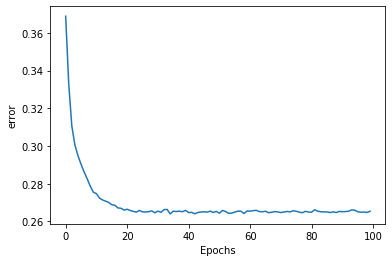

In [128]:
rbm = RBM(vis_unit = 100, hidd_unit=10)
model = rbm.learn(training_data=new_data_train, learning_rate=0.01,epochs=100, CD_k=2, batch_size=50)

plt.plot(np.arange(100), rbm.error_history)
plt.xlabel("Epochs")
plt.ylabel("error")

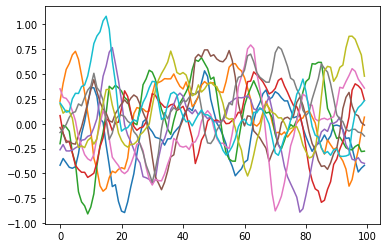

In [129]:
plt.plot(np.arange(100), rbm.W)

In [324]:
recons_array = rbm.reconstruction(1, new_data_test.T)

In [325]:
recons_array.shape

(100, 1000)

In [326]:
def energy_ising_1d(configuration,J,h):
    num_spins = len(configuration)
    energy = 0.0
    for i in range(num_spins):
        spini = configuration[i]
        #set the value of spin i+1, make sure to test if i+1<num_spins, and otherwise account for periodic boundaries
        #you can do this with an if statement if you have to
        ip1 = (i+1)%num_spins
        spinip1 = configuration[ip1]
        
        energy = energy - J * (spini * spinip1) - h*spini
        
    return energy

def energy_batch(configs,J,h):
    energies = np.array([energy_ising_1d(config,J,h) for config in configs])
    
    return energies

def avg_energy(configs,J,h):
    return np.mean(energy_batch(configs,J,h))

In [327]:
recons_energy =  energy_batch(recons_array.T,J=1,h=0)

In [329]:
recons_energy.shape

(1000,)

In [333]:
data_energy = energy_batch(new_data_test,J=1,h=0)

In [334]:
data_energy.shape

(1000,)

Text(0.5, 0, 'data_energy')

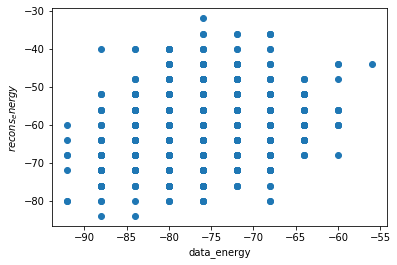

In [335]:
plt.scatter(data_energy, recons_energy)
plt.ylabel("$recons_energy$")
plt.xlabel("data_energy")

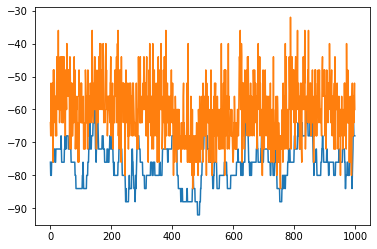

In [336]:
plt.plot(data_energy)
plt.plot(recons_energy)

In [337]:
mean_data = np.mean(data_energy)

In [338]:
mean_data

-76.356

In [339]:
mean_recons = np.mean(recons_energy)

In [340]:
mean_recons

-60.584

In [218]:
std_data = np.std(data_energy)

In [219]:
std_data 

6.159912255868585

In [220]:
std_recons = np.std(recons_energy)

In [221]:
std_recons

7.986488339689729

In [56]:
rbm.W

array([[-0.1857538 , -0.16874663,  0.07933101, ..., -0.00136765,
         0.0749958 , -0.1064826 ],
       [-0.18776039, -0.02426432,  0.00921802, ..., -0.06993061,
         0.14235403,  0.0215044 ],
       [-0.05306904, -0.08850899,  0.21051344, ..., -0.23064448,
        -0.14460605,  0.09208815],
       ...,
       [-0.08194391,  0.00069581,  0.03462403, ...,  0.03665591,
         0.08544139, -0.18500211],
       [-0.09232438,  0.08725839,  0.09535216, ..., -0.02469203,
         0.00254883, -0.02893692],
       [ 0.11191829,  0.02225424,  0.04114218, ...,  0.09589833,
         0.10569549,  0.02064088]])